1. 실험환경 Set-up
- batch size, epoch 등을 변경

2. 데이터 준비하기 
- augmentation 고려

3. 데이터 시각화
- augmentation 후 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리 되었는 지 확인

4. CNN 모델링
- convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 변경
- batchnormalization과 dropout 구성 변경해보기

5. 데이터 imbalance 처리
- class_weight를 생략한다면?

6. 모델 훈련
- optimizer rate과 learning rate등의 변화를 고려

7. 결과 확인과 시각화
- 테스트 데이터로 훈련된 모델을 평가 (accuracy, recall)
- 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석

# 1. Setup

In [41]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [42]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# Batch size과 Epochs
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# 2. 데이터 가죠오기

In [43]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [44]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [45]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [46]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


batch size == 100 일 때 "100개의 문제를 동시에 풀고 정답을 확인하고 정답률을 증가한다."

In [47]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [48]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [49]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [50]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [51]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [52]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [53]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.
prepare_for_training()함수를 정의해서 데이터를 변환.

- 'shuffle()'
을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택.

- 'repeat()'
를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰준다.

- 'batch()'
를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.

- 'prefetch()'
를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

# data augment 적용해보기

- ! data augmentation 이란 부족한 데이터셋을 augment 하여 규모를 키울 수 있는 방법이다.

- ! mirroring, random cropping, rotation, shearing, local wraping 등 다양한 방법이 있다.
RGB를 이용한 새변환 방법도 있다.

! 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

In [54]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

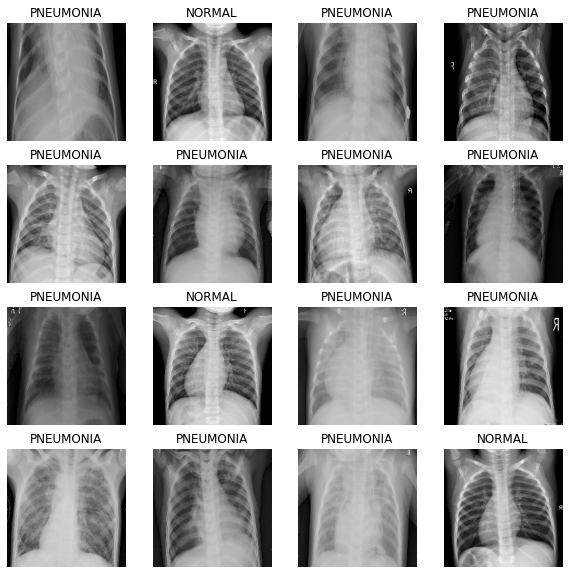

In [55]:

def show_batch(image_batch, label_batch): # 결과 사진을 보여주는 show_batch() 
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [56]:
# augmentation 적용 이전 사진

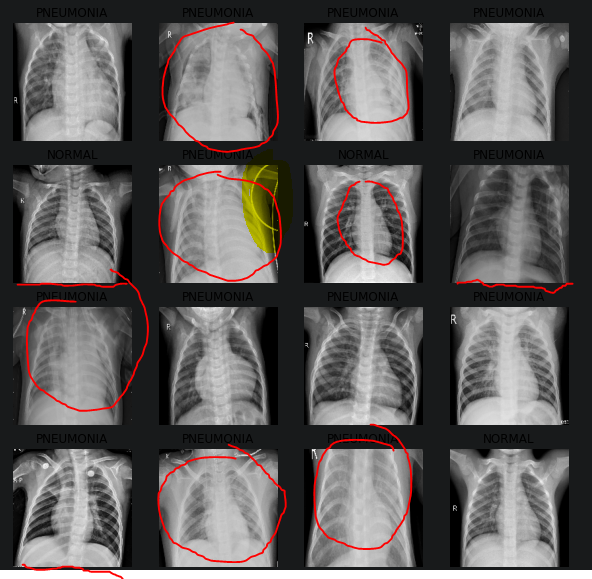

간단한 소감: 좌우반전은 잘 된 듯 하다. 어떤 사진은 더 선명해진 것 같고 또 어떤 사진은 오히려 더 흐려진 것 같다는 특이점도 봤다.

# 4. CNN 모델링

conv_block() 2번 진행후 batch normalization을 통해 graident vanishing, gradient exploding을 해결
후에 max pooling

In [57]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

dense block 아래와 같이 만듬

In [58]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

여기서 알아볼 것: batch normalization, dropout을 각각 하나씩만 사용했을 땐 어떤 결과가 나올 지 확인해보기


동시에 쓰면 효율성이 떨어진다고 한다

나중에 또 참고하자:
https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf


In [72]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

weight balancing - 한 라벨이 너무 많은 경우 imbalance라 칭하고 이를 해결해주는 기법이라 한다
weight balancing은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다

In [60]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  
# weight_for_0은 'Normal' 이미지에 사용할 weight

weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 
# weight_for_0은 Normal 이미지에 사용할 weight를 weight_for_1 Pneumonia 이미지에 사용할 weight를 세팅합니다

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [61]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [62]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 63s 189ms/step - loss: 0.4391 - accuracy: 0.7919 - precision: 0.9388 - recall: 0.7704 - val_loss: 0.6911 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2487 - accuracy: 0.9004 - precision: 0.9712 - recall: 0.8924 - val_loss: 1.3293 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2041 - accuracy: 0.9260 - precision: 0.9749 - recall: 0.9244 - val_loss: 0.1056 - val_accuracy: 0.9683 - val_precision: 0.9766 - val_recall: 0.9804
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2009 - accuracy: 0.9181 - precision: 0.9723 - recall: 0.9159 - val_loss: 0.0946 - val_accuracy: 0.9663 - val_precision: 0.9906 - val_recall: 0.9634
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1909 - accura

# 7. 결과 확인

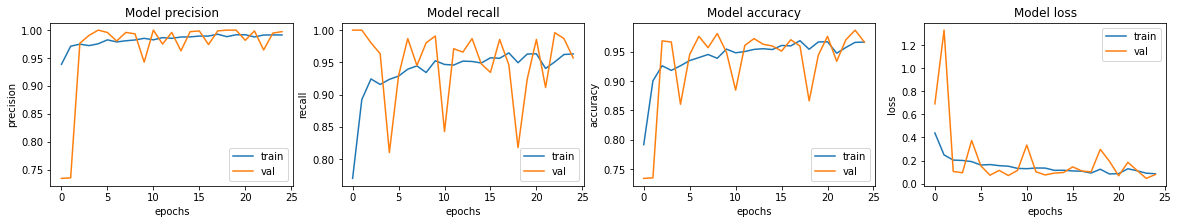

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [69]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 113ms/step - loss: 0.7708 - accuracy: 0.8205 - precision: 0.7860 - recall: 0.9795
Loss: 0.7707607746124268,
Accuracy: 0.8205128312110901,
Precision: 0.7860082387924194,
Recall: 0.9794871807098389


# 익스 그대로 진행 해본 결과
_____________________________________

Epoch 1/25
261/261 [==============================] - 65s 193ms/step - loss: 0.3687 - accuracy: 0.8257 - precision: 0.9535 - recall: 0.8050 - val_loss: 0.8609 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2430 - accuracy: 0.9092 - precision: 0.9697 - recall: 0.9064 - val_loss: 1.2635 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2020 - accuracy: 0.9241 - precision: 0.9755 - recall: 0.9212 - val_loss: 0.6882 - val_accuracy: 0.7385 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1695 - accuracy: 0.9349 - precision: 0.9794 - recall: 0.9321 - val_loss: 0.0826 - val_accuracy: 0.9702 - val_precision: 0.9867 - val_recall: 0.9725
Epoch 5/25
261/261 [==============================] - 52s 200ms/step - loss: 0.1693 - accuracy: 0.9409 - precision: 0.9808 - recall: 0.9388 - val_loss: 0.1233 - val_accuracy: 0.9510 - val_precision: 0.9450 - val_recall: 0.9908
Epoch 6/25
261/261 [==============================] - 57s 219ms/step - loss: 0.1716 - accuracy: 0.9380 - precision: 0.9785 - recall: 0.9373 - val_loss: 0.2144 - val_accuracy: 0.9173 - val_precision: 0.9971 - val_recall: 0.8899
Epoch 7/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1482 - accuracy: 0.9397 - precision: 0.9818 - recall: 0.9362 - val_loss: 0.4406 - val_accuracy: 0.8096 - val_precision: 0.7940 - val_recall: 1.0000
Epoch 8/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1520 - accuracy: 0.9416 - precision: 0.9825 - recall: 0.9382 - val_loss: 0.1052 - val_accuracy: 0.9644 - val_precision: 0.9678 - val_recall: 0.9843
Epoch 9/25
261/261 [==============================] - 47s 182ms/step - loss: 0.1393 - accuracy: 0.9485 - precision: 0.9846 - recall: 0.9457 - val_loss: 0.2045 - val_accuracy: 0.9154 - val_precision: 0.8974 - val_recall: 0.9987
Epoch 10/25
261/261 [==============================] - 47s 181ms/step - loss: 0.1196 - accuracy: 0.9538 - precision: 0.9866 - recall: 0.9508 - val_loss: 0.0859 - val_accuracy: 0.9731 - val_precision: 0.9706 - val_recall: 0.9934
Epoch 11/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1435 - accuracy: 0.9452 - precision: 0.9810 - recall: 0.9447 - val_loss: 0.6419 - val_accuracy: 0.7490 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 12/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1421 - accuracy: 0.9490 - precision: 0.9846 - recall: 0.9463 - val_loss: 0.1705 - val_accuracy: 0.9250 - val_precision: 0.9086 - val_recall: 0.9987
Epoch 13/25
261/261 [==============================] - 47s 181ms/step - loss: 0.1215 - accuracy: 0.9574 - precision: 0.9864 - recall: 0.9559 - val_loss: 0.1267 - val_accuracy: 0.9567 - val_precision: 0.9972 - val_recall: 0.9436
Epoch 14/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1046 - accuracy: 0.9619 - precision: 0.9865 - recall: 0.9620 - val_loss: 0.2731 - val_accuracy: 0.9038 - val_precision: 1.0000 - val_recall: 0.8689
Epoch 15/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1012 - accuracy: 0.9610 - precision: 0.9910 - recall: 0.9564 - val_loss: 0.1125 - val_accuracy: 0.9596 - val_precision: 0.9986 - val_recall: 0.9461
Epoch 16/25
261/261 [==============================] - 48s 183ms/step - loss: 0.0923 - accuracy: 0.9655 - precision: 0.9904 - recall: 0.9631 - val_loss: 0.1267 - val_accuracy: 0.9587 - val_precision: 0.9592 - val_recall: 0.9856
Epoch 17/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1021 - accuracy: 0.9646 - precision: 0.9910 - recall: 0.9610 - val_loss: 0.1044 - val_accuracy: 0.9663 - val_precision: 0.9892 - val_recall: 0.9645
Epoch 18/25
261/261 [==============================] - 46s 177ms/step - loss: 0.0832 - accuracy: 0.9679 - precision: 0.9917 - recall: 0.9650 - val_loss: 0.0654 - val_accuracy: 0.9750 - val_precision: 0.9894 - val_recall: 0.9764
Epoch 19/25
261/261 [==============================] - 47s 181ms/step - loss: 0.1415 - accuracy: 0.9502 - precision: 0.9859 - recall: 0.9467 - val_loss: 0.3344 - val_accuracy: 0.8740 - val_precision: 1.0000 - val_recall: 0.8281
Epoch 20/25
261/261 [==============================] - 46s 178ms/step - loss: 0.1084 - accuracy: 0.9593 - precision: 0.9877 - recall: 0.9570 - val_loss: 0.0771 - val_accuracy: 0.9712 - val_precision: 0.9829 - val_recall: 0.9777
Epoch 21/25
261/261 [==============================] - 46s 178ms/step - loss: 0.0728 - accuracy: 0.9734 - precision: 0.9947 - recall: 0.9695 - val_loss: 0.0815 - val_accuracy: 0.9721 - val_precision: 0.9803 - val_recall: 0.9816
Epoch 22/25
261/261 [==============================] - 47s 180ms/step - loss: 0.0891 - accuracy: 0.9703 - precision: 0.9921 - recall: 0.9677 - val_loss: 0.0826 - val_accuracy: 0.9692 - val_precision: 0.9973 - val_recall: 0.9606
Epoch 23/25
261/261 [==============================] - 46s 176ms/step - loss: 0.0644 - accuracy: 0.9775 - precision: 0.9964 - recall: 0.9734 - val_loss: 0.1162 - val_accuracy: 0.9615 - val_precision: 1.0000 - val_recall: 0.9474
Epoch 24/25
261/261 [==============================] - 47s 181ms/step - loss: 0.0773 - accuracy: 0.9741 - precision: 0.9940 - recall: 0.9709 - val_loss: 0.0517 - val_accuracy: 0.9788 - val_precision: 0.9894 - val_recall: 0.9817
Epoch 25/25
261/261 [==============================] - 47s 180ms/step - loss: 0.0839 - accuracy: 0.9691 - precision: 0.9921 - recall: 0.9663 - val_loss: 0.0682 - val_accuracy: 0.9740 - val_precision: 0.9933 - val_recall: 0.9712


_________________________________________
# 결과 확인

39/39 [==============================] - 4s 112ms/step - loss: 0.8782 - accuracy: 0.7804 - precision: 0.7437 - recall: 0.9897
Loss: 0.8782310485839844,
Accuracy: 0.7804487347602844,
Precision: 0.7437379360198975,
Recall: 0.9897435903549194

# data augmentation 적용 후 결과


Epoch 1/25
261/261 [==============================] - 63s 189ms/step - loss: 0.4391 - accuracy: 0.7919 - precision: 0.9388 - recall: 0.7704 - val_loss: 0.6911 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2487 - accuracy: 0.9004 - precision: 0.9712 - recall: 0.8924 - val_loss: 1.3293 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2041 - accuracy: 0.9260 - precision: 0.9749 - recall: 0.9244 - val_loss: 0.1056 - val_accuracy: 0.9683 - val_precision: 0.9766 - val_recall: 0.9804
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2009 - accuracy: 0.9181 - precision: 0.9723 - recall: 0.9159 - val_loss: 0.0946 - val_accuracy: 0.9663 - val_precision: 0.9906 - val_recall: 0.9634
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1909 - accuracy: 0.9260 - precision: 0.9756 - recall: 0.9238 - val_loss: 0.3737 - val_accuracy: 0.8606 - val_precision: 1.0000 - val_recall: 0.8105
Epoch 6/25
261/261 [==============================] - 54s 206ms/step - loss: 0.1614 - accuracy: 0.9349 - precision: 0.9826 - recall: 0.9288 - val_loss: 0.1551 - val_accuracy: 0.9452 - val_precision: 0.9958 - val_recall: 0.9294
Epoch 7/25
261/261 [==============================] - 47s 181ms/step - loss: 0.1653 - accuracy: 0.9399 - precision: 0.9789 - recall: 0.9395 - val_loss: 0.0730 - val_accuracy: 0.9760 - val_precision: 0.9805 - val_recall: 0.9869
Epoch 8/25
261/261 [==============================] - 46s 177ms/step - loss: 0.1559 - accuracy: 0.9452 - precision: 0.9809 - recall: 0.9446 - val_loss: 0.1149 - val_accuracy: 0.9567 - val_precision: 0.9959 - val_recall: 0.9452
Epoch 9/25
261/261 [==============================] - 46s 178ms/step - loss: 0.1510 - accuracy: 0.9387 - precision: 0.9824 - recall: 0.9344 - val_loss: 0.0703 - val_accuracy: 0.9808 - val_precision: 0.9934 - val_recall: 0.9804
Epoch 10/25
261/261 [==============================] - 47s 181ms/step - loss: 0.1321 - accuracy: 0.9543 - precision: 0.9853 - recall: 0.9526 - val_loss: 0.1156 - val_accuracy: 0.9490 - val_precision: 0.9427 - val_recall: 0.9908
Epoch 11/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1296 - accuracy: 0.9480 - precision: 0.9826 - recall: 0.9469 - val_loss: 0.3342 - val_accuracy: 0.8846 - val_precision: 1.0000 - val_recall: 0.8429
Epoch 12/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1355 - accuracy: 0.9502 - precision: 0.9866 - recall: 0.9459 - val_loss: 0.1028 - val_accuracy: 0.9606 - val_precision: 0.9750 - val_recall: 0.9712
Epoch 13/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1349 - accuracy: 0.9538 - precision: 0.9853 - recall: 0.9520 - val_loss: 0.0754 - val_accuracy: 0.9721 - val_precision: 0.9960 - val_recall: 0.9660
Epoch 14/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1154 - accuracy: 0.9550 - precision: 0.9877 - recall: 0.9515 - val_loss: 0.0911 - val_accuracy: 0.9625 - val_precision: 0.9629 - val_recall: 0.9869
Epoch 15/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1158 - accuracy: 0.9535 - precision: 0.9879 - recall: 0.9491 - val_loss: 0.0967 - val_accuracy: 0.9596 - val_precision: 0.9973 - val_recall: 0.9478
Epoch 16/25
261/261 [==============================] - 48s 183ms/step - loss: 0.1102 - accuracy: 0.9605 - precision: 0.9893 - recall: 0.9571 - val_loss: 0.1452 - val_accuracy: 0.9510 - val_precision: 0.9986 - val_recall: 0.9346
Epoch 17/25
261/261 [==============================] - 46s 178ms/step - loss: 0.1076 - accuracy: 0.9598 - precision: 0.9894 - recall: 0.9564 - val_loss: 0.1100 - val_accuracy: 0.9702 - val_precision: 0.9742 - val_recall: 0.9856
Epoch 18/25
261/261 [==============================] - 48s 184ms/step - loss: 0.0918 - accuracy: 0.9686 - precision: 0.9927 - recall: 0.9648 - val_loss: 0.1016 - val_accuracy: 0.9596 - val_precision: 0.9986 - val_recall: 0.9463
Epoch 19/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1251 - accuracy: 0.9540 - precision: 0.9883 - recall: 0.9495 - val_loss: 0.2970 - val_accuracy: 0.8663 - val_precision: 1.0000 - val_recall: 0.8181
Epoch 20/25
261/261 [==============================] - 46s 177ms/step - loss: 0.0837 - accuracy: 0.9665 - precision: 0.9917 - recall: 0.9630 - val_loss: 0.1934 - val_accuracy: 0.9442 - val_precision: 1.0000 - val_recall: 0.9241
Epoch 21/25
261/261 [==============================] - 47s 182ms/step - loss: 0.0869 - accuracy: 0.9667 - precision: 0.9917 - recall: 0.9633 - val_loss: 0.0681 - val_accuracy: 0.9760 - val_precision: 0.9817 - val_recall: 0.9856
Epoch 22/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1288 - accuracy: 0.9473 - precision: 0.9878 - recall: 0.9406 - val_loss: 0.1845 - val_accuracy: 0.9337 - val_precision: 0.9986 - val_recall: 0.9111
Epoch 23/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1117 - accuracy: 0.9571 - precision: 0.9913 - recall: 0.9508 - val_loss: 0.1146 - val_accuracy: 0.9702 - val_precision: 0.9646 - val_recall: 0.9961
Epoch 24/25
261/261 [==============================] - 47s 181ms/step - loss: 0.0908 - accuracy: 0.9658 - precision: 0.9914 - recall: 0.9623 - val_loss: 0.0456 - val_accuracy: 0.9865 - val_precision: 0.9947 - val_recall: 0.9869
Epoch 25/25
261/261 [==============================] - 46s 178ms/step - loss: 0.0857 - accuracy: 0.9662 - precision: 0.9914 - recall: 0.9631 - val_loss: 0.0791 - val_accuracy: 0.9663 - val_precision: 0.9973 - val_recall: 0.9570


__________
# 결과 확인

39/39 [==============================] - 4s 113ms/step - loss: 0.7708 - accuracy: 0.8205 - precision: 0.7860 - recall: 0.9795
Loss: 0.7707607746124268,
Accuracy: 0.8205128312110901,
Precision: 0.7860082387924194,
Recall: 0.9794871807098389

# augmentation 했을 때 안했을 때 보다 loss 가 .1 정도 줄었고 정확도도 0.7804에서 0.8205 로 증가했다

# 중간 회고:

- dropout을 어떻게 빼고 모델링 하는 지, batch normalization을 어떻게 제거하고 모델을 돌리는 지 몇 시간 동안 고뇌하다 이를 위한 새로운 함수를 추가해야 된다는 것을 뒤늦게 알았다. 지금 까지 익스를 진행하면서 겪었던 어려움 및 고민들이 한 순간에 풀렸다.

- 정답은 결국 익스에서 시키는 것을 위한 나만의 코드를 새로 짤 줄 알아야 된다는 것이었다. 아이펠 진행한 지 한달이 지나고 익스 9번째 때 이걸 알아차렸던 것이 정말......

- 급한 마음에 다른분께 얻은 코드로 일단 진행을 해본다.

In [74]:
def conv_block(layer, filters):
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(layer)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    return x

In [75]:
def dense_block(layer, units, dropout_rate=0.5, dropout=True):
    x = tf.keras.layers.Dense(units, activation='relu')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [76]:
def build_model(dropout=True):
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    
    x = conv_block(x, 128)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = conv_block(x, 256)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    return model

# 모델링 단계에서 코드를 많이 만진 것 같고 cnn layer 들을 전부 x 라는 변수에 지정해준 것 같다. (후에 다시 사용하기 편리하기 위해?)


In [77]:
 with tf.device('/GPU:0'):
    model_no_drop = build_model(dropout=False)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_drop.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [80]:
with tf.device('/GPU:0'):
    history_no_drop = model_no_drop.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 189ms/step - loss: 0.3680 - accuracy: 0.8199 - precision: 0.9602 - recall: 0.7909 - val_loss: 0.7185 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2168 - accuracy: 0.9186 - precision: 0.9769 - recall: 0.9120 - val_loss: 1.1113 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2148 - accuracy: 0.9195 - precision: 0.9724 - recall: 0.9178 - val_loss: 0.5916 - val_accuracy: 0.7567 - val_precision: 0.7520 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1782 - accuracy: 0.9325 - precision: 0.9799 - recall: 0.9282 - val_loss: 0.1408 - val_accuracy: 0.9538 - val_precision: 0.9931 - val_recall: 0.9436
Epoch 5/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1638 - accura

In [82]:
loss, acc, prec, rec = model_no_drop.evaluate(test_ds)

39/39 [==============================] - 4s 105ms/step - loss: 0.5173 - accuracy: 0.8526 - precision: 0.8296 - recall: 0.9615


# augmentation 적용, dropout 제거 후기

Epoch 1/25
261/261 [==============================] - 58s 189ms/step - loss: 0.3680 - accuracy: 0.8199 - precision: 0.9602 - recall: 0.7909 - val_loss: 0.7185 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2168 - accuracy: 0.9186 - precision: 0.9769 - recall: 0.9120 - val_loss: 1.1113 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2148 - accuracy: 0.9195 - precision: 0.9724 - recall: 0.9178 - val_loss: 0.5916 - val_accuracy: 0.7567 - val_precision: 0.7520 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1782 - accuracy: 0.9325 - precision: 0.9799 - recall: 0.9282 - val_loss: 0.1408 - val_accuracy: 0.9538 - val_precision: 0.9931 - val_recall: 0.9436
Epoch 5/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1638 - accuracy: 0.9385 - precision: 0.9828 - recall: 0.9338 - val_loss: 0.0845 - val_accuracy: 0.9731 - val_precision: 0.9817 - val_recall: 0.9817
Epoch 6/25
261/261 [==============================] - 52s 199ms/step - loss: 0.1619 - accuracy: 0.9432 - precision: 0.9835 - recall: 0.9394 - val_loss: 4.0424 - val_accuracy: 0.2981 - val_precision: 1.0000 - val_recall: 0.0445
Epoch 7/25
261/261 [==============================] - 55s 209ms/step - loss: 0.1666 - accuracy: 0.9389 - precision: 0.9818 - recall: 0.9356 - val_loss: 0.1449 - val_accuracy: 0.9433 - val_precision: 0.9972 - val_recall: 0.9258
Epoch 8/25
261/261 [==============================] - 47s 182ms/step - loss: 0.1427 - accuracy: 0.9459 - precision: 0.9838 - recall: 0.9424 - val_loss: 0.1343 - val_accuracy: 0.9442 - val_precision: 0.9958 - val_recall: 0.9280
Epoch 9/25
261/261 [==============================] - 48s 183ms/step - loss: 0.1528 - accuracy: 0.9406 - precision: 0.9821 - recall: 0.9373 - val_loss: 0.3673 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.7958
Epoch 10/25
261/261 [==============================] - 47s 181ms/step - loss: 0.1372 - accuracy: 0.9425 - precision: 0.9881 - recall: 0.9341 - val_loss: 0.1109 - val_accuracy: 0.9577 - val_precision: 0.9986 - val_recall: 0.9438
Epoch 11/25
261/261 [==============================] - 47s 182ms/step - loss: 0.1325 - accuracy: 0.9485 - precision: 0.9852 - recall: 0.9447 - val_loss: 0.1922 - val_accuracy: 0.9221 - val_precision: 0.9886 - val_recall: 0.9046
Epoch 12/25
261/261 [==============================] - 47s 181ms/step - loss: 0.1412 - accuracy: 0.9471 - precision: 0.9846 - recall: 0.9438 - val_loss: 0.1027 - val_accuracy: 0.9596 - val_precision: 1.0000 - val_recall: 0.9450
Epoch 13/25
261/261 [==============================] - 46s 176ms/step - loss: 0.1791 - accuracy: 0.9298 - precision: 0.9783 - recall: 0.9264 - val_loss: 0.0829 - val_accuracy: 0.9712 - val_precision: 0.9766 - val_recall: 0.9843
Epoch 14/25
261/261 [==============================] - 47s 182ms/step - loss: 0.1293 - accuracy: 0.9507 - precision: 0.9866 - recall: 0.9465 - val_loss: 0.2620 - val_accuracy: 0.9173 - val_precision: 1.0000 - val_recall: 0.8876
Epoch 15/25
261/261 [==============================] - 45s 173ms/step - loss: 0.1337 - accuracy: 0.9461 - precision: 0.9861 - recall: 0.9407 - val_loss: 0.3713 - val_accuracy: 0.8635 - val_precision: 1.0000 - val_recall: 0.8141
Epoch 16/25
261/261 [==============================] - 45s 172ms/step - loss: 0.1063 - accuracy: 0.9605 - precision: 0.9891 - recall: 0.9577 - val_loss: 0.0790 - val_accuracy: 0.9683 - val_precision: 0.9893 - val_recall: 0.9673
Epoch 17/25
261/261 [==============================] - 47s 182ms/step - loss: 0.1152 - accuracy: 0.9557 - precision: 0.9896 - recall: 0.9504 - val_loss: 0.5560 - val_accuracy: 0.8135 - val_precision: 0.9983 - val_recall: 0.7477
Epoch 18/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1214 - accuracy: 0.9526 - precision: 0.9882 - recall: 0.9475 - val_loss: 0.0753 - val_accuracy: 0.9740 - val_precision: 0.9767 - val_recall: 0.9882
Epoch 19/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1104 - accuracy: 0.9569 - precision: 0.9899 - recall: 0.9516 - val_loss: 0.0661 - val_accuracy: 0.9808 - val_precision: 0.9831 - val_recall: 0.9908
Epoch 20/25
261/261 [==============================] - 47s 180ms/step - loss: 0.1200 - accuracy: 0.9547 - precision: 0.9893 - recall: 0.9495 - val_loss: 0.1040 - val_accuracy: 0.9558 - val_precision: 0.9972 - val_recall: 0.9424
Epoch 21/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1067 - accuracy: 0.9591 - precision: 0.9906 - recall: 0.9539 - val_loss: 0.2291 - val_accuracy: 0.9096 - val_precision: 1.0000 - val_recall: 0.8773
Epoch 22/25
261/261 [==============================] - 47s 180ms/step - loss: 0.0916 - accuracy: 0.9667 - precision: 0.9930 - recall: 0.9620 - val_loss: 0.1489 - val_accuracy: 0.9433 - val_precision: 1.0000 - val_recall: 0.9231
Epoch 23/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1026 - accuracy: 0.9569 - precision: 0.9870 - recall: 0.9544 - val_loss: 0.3394 - val_accuracy: 0.8721 - val_precision: 1.0000 - val_recall: 0.8261
Epoch 24/25
261/261 [==============================] - 47s 179ms/step - loss: 0.0908 - accuracy: 0.9636 - precision: 0.9914 - recall: 0.9597 - val_loss: 0.3180 - val_accuracy: 0.8885 - val_precision: 1.0000 - val_recall: 0.8480
Epoch 25/25
261/261 [==============================] - 49s 189ms/step - loss: 0.0924 - accuracy: 0.9646 - precision: 0.9926 - recall: 0.9593 - val_loss: 0.1296 - val_accuracy: 0.9423 - val_precision: 0.9958 - val_recall: 0.9254
                                
                            
__________
# 결과 확인
                                
 39/39 [==============================] - 4s 105ms/step - loss: 0.5173 - accuracy: 0.8526 - precision: 0.8296 - recall: 0.9615

# 최종 회고:

dropout 제거를 했을 때 Loss 가 0.5173으로 줄었고 정확도도 0.8526로 가장 높게 나왔다. Batch normalization을 제거 했을 때와 다른 모델링 기법들을 찾아가며 실행하고 싶지만 이를 코딩 하는 방법 부터 먼저 찾아야 할 것 같다. 다음 익스 때는 모델링에 활용되는 코드를 더욱 유심히 보고 그와 동일한 기능을 하는 나만의 코드를 짤 필요성을 느꼈다.

이번 익스 때는 설명이 매우 친절, 또는 좋은 정보들이 담긴 링크들이 많아서 공부하기에 매우 편하고 또 배우는 재미를 느낀 것 같다. CNN에 대한 정리가 조금 씩 되어가는 것 같고 모델링을 제대로 해보고 싶은 욕심이 생겼다.